In [41]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import sys
import requests
import io
from sklearn import naive_bayes
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sas7bdat import SAS7BDAT
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import urllib
import itertools

% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [141]:
url = 'http://www1.nyc.gov/assets/doh/downloads/sas/episrv/chs2014_public.sas7bdat'
r = urllib.request.urlretrieve(url)

In [4]:
with SAS7BDAT('chs2014.sas7bdat') as f:
    df = f.to_data_frame()

In [5]:
df.head()

,mood9,mood8,mood11,demog55,demog17,nutrition1,borough,newrace,cid,uhf34,...,dphonew06,flag_imputed_pov200,imputed_pov200,flag_imputed_povertygroup,imputed_povertygroup,flag_imputed_povgroup3,imputed_povgroup3,bthregion2,hhsize,numadults2
0,2.0,1.0,1.0,NaN,6.0,1.0,3.0,1.0,1500001.0,17.0,...,4.0,0.0,1.0,0.0,2.0,0.0,1.0,20.0,1.0,1.0
1,2.0,2.0,2.0,NaN,6.0,2.0,4.0,2.0,1500002.0,30.0,...,4.0,0.0,2.0,0.0,3.0,0.0,2.0,18.0,1.0,1.0
2,2.0,2.0,2.0,NaN,6.0,4.0,4.0,2.0,1500003.0,32.0,...,4.0,0.0,1.0,0.0,2.0,0.0,1.0,20.0,3.0,2.0
3,2.0,2.0,2.0,NaN,5.0,5.0,2.0,1.0,1500004.0,13.0,...,4.0,0.0,1.0,0.0,2.0,0.0,1.0,20.0,1.0,1.0
4,2.0,2.0,2.0,NaN,6.0,0.0,2.0,2.0,1500005.0,16.0,...,3.0,0.0,2.0,0.0,4.0,0.0,3.0,20.0,1.0,1.0


In [6]:
# select columns of interest, drop na and dummify 

keep_columns = ['sickadvice14', 
                'education', 
                'maritalstatus14',
                'usborn', 'sexualid', 
                 'insured',
                'athomelanguage14']

df2 = df[keep_columns]
df2.dropna(inplace = True)

df_reduced = pd.get_dummies(df2, columns = keep_columns[1:])

Y = df_reduced[keep_columns[0]]
X = df_reduced[df_reduced.columns[1:]]

C:\Users\shibbie\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
labels = ['Private Dr', 'Community Health', 'Hospital Outpatient', 'ED/Urgent Care', 'Alt Health', 
         'Family/Friend/Self', 'Non-Hosp. Clinic', 'Other', 'No Usual']

In [86]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar(shrink = .75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

Naive Bayes - Bernoulli
For training size of 1550.7999999999997
2131 misclassified data out of 6204, 34.3488 %
For training size of 3101.6000000000004
1551 misclassified data out of 4653, 33.3333 %
For training size of 4652.4
1068 misclassified data out of 3102, 34.4294 %
For training size of 6203.200000000001
526 misclassified data out of 1551, 33.9136 %


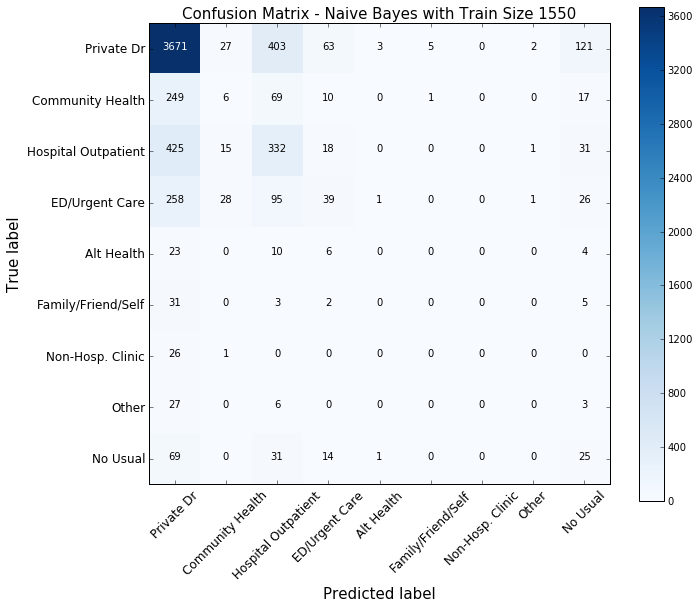

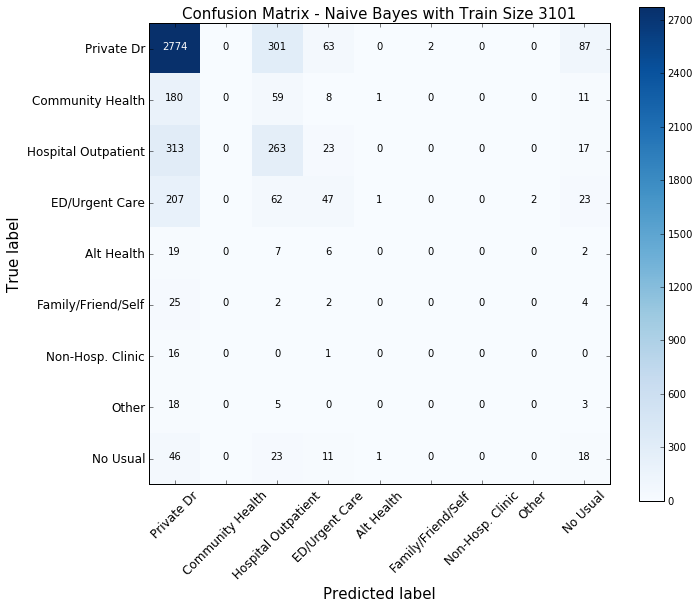

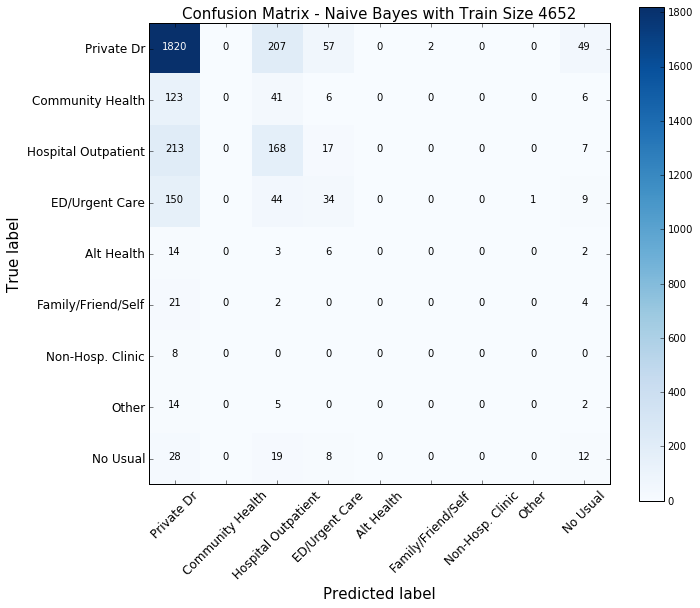

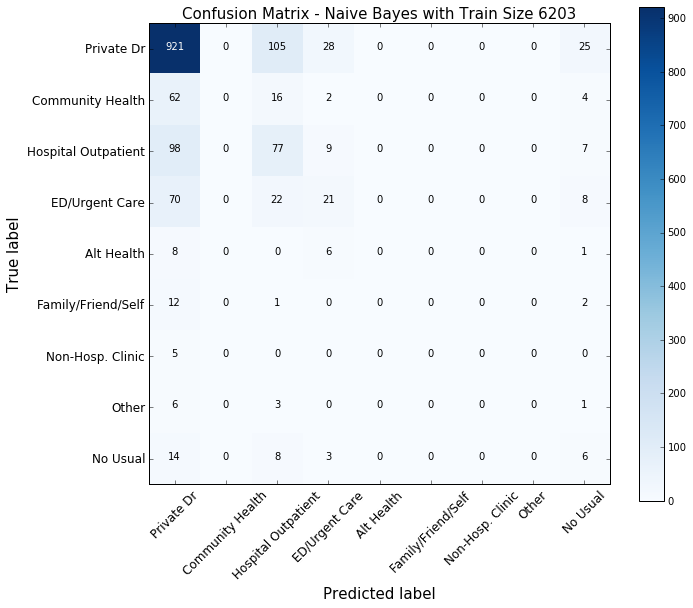

In [98]:
print("Naive Bayes - Bernoulli")
scores_nb = np.zeros(4 * 8).reshape(4, 8)

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape

    gnb = naive_bayes.BernoulliNB()
    gnb.fit(X_train,Y_train)
    ypred_gnb = gnb.predict(X_test)
    incorrect = sum(Y_test != ypred_gnb) / ts 

    #scores_gnb = cross_val_score(gnb, X, Y, cv = ShuffleSplit(n_splits = 8, test_size = n))
    #scores_nb[i] = scores_gnb
    
    print('For training size of {0}'.format(len(X) * (1 - n)))
    print("{0} misclassified data out of {1}, {2} %".format(sum(Y_test != ypred_gnb), ts, round(incorrect * 100, 4)))
    #print ('Average Cross Valid Score {0} %'.format(round(mean(scores_gnb) * 100, 4)))
    conf_m = confusion_matrix(Y_test, ypred_gnb)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - Naive Bayes with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_NB_{0}.jpg'.format(str(len(X_train))))

In [88]:
print("Naive Bayes - Bernoulli")
scores_nb = np.zeros(4 * 8).reshape(4, 8)

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = n, random_state=3)
    #ts, = Y_test.shape

    gnb = naive_bayes.BernoulliNB()
    #gnb.fit(X_train,Y_train)
    #ypred_gnb = gnb.predict(X_test)
    #incorrect = sum(Y_test != ypred_gnb) / ts 

    scores_gnb = cross_val_score(gnb, X, Y, cv = ShuffleSplit(n_splits = 8, test_size = n))
    scores_nb[i] = scores_gnb
    
    print('For training size of {0}'.format(len(X) * (1 - n)))
    #print("{0} misclassified data out of {1}, {2} %".format(sum(Y_test != ypred_gnb), ts, round(incorrect * 100, 4)))
    print ('Average Cross Valid Score {0} %'.format(round(mean(scores_gnb) * 100, 4)))

Naive Bayes - Bernoulli
For training size of 1550.7999999999997
Average Cross Valid Score 66.1549 %
For training size of 3101.6000000000004
Average Cross Valid Score 66.4625 %
For training size of 4652.4
Average Cross Valid Score 66.6546 %
For training size of 6203.200000000001
Average Cross Valid Score 66.9407 %


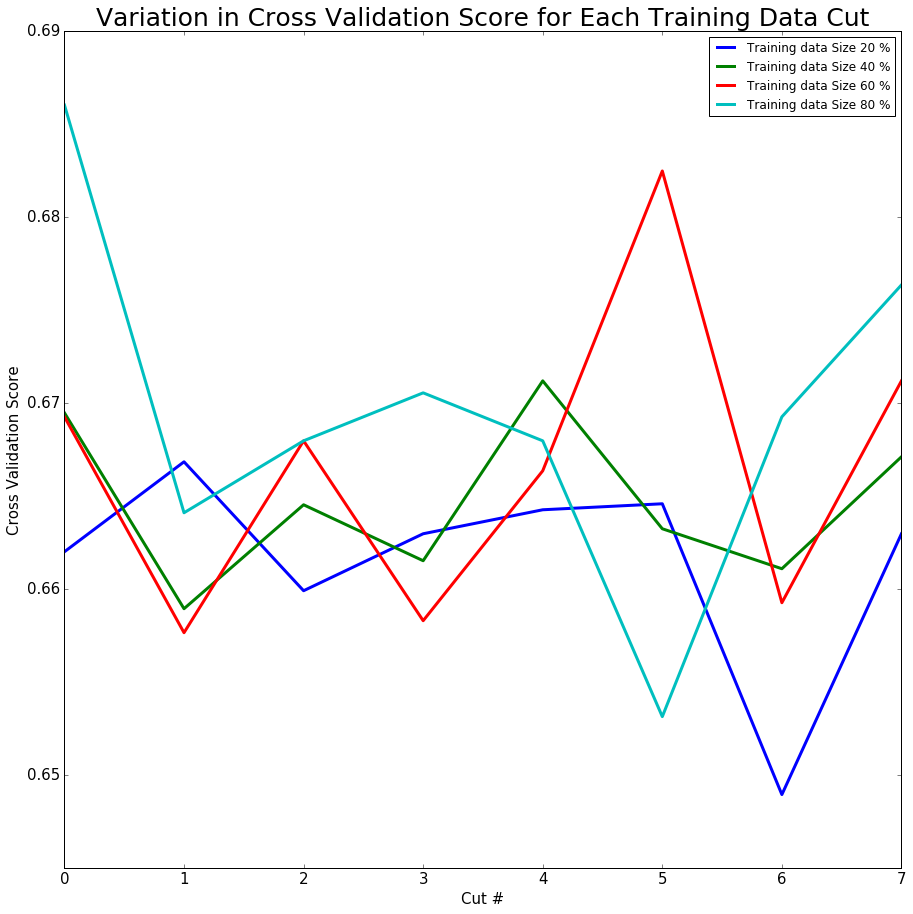

In [89]:
fig, ax = pl.subplots(figsize = (15, 15))
scores_ = np.zeros(4*8).reshape(4, 8)

for i, n in enumerate([0.2, 0.4, 0.6, 0.8]):
    ax.plot(range(0,8), scores_nb[i], label = 'Training data Size {0} %'.format(int(round(n * 100))), lw = 3)

pl.xlabel('Cut #', fontsize = 15)
pl.ylabel('Cross Validation Score', fontsize = 15)
pl.xticks(fontsize = 15)
pl.yticks(fontsize = 15)
pl.title('Variation in Cross Validation Score for Each Training Data Cut', fontsize = 25)
pl.legend()

----------SVM Linear----------
For training size of 1550
1909 misclassified data out of 6204 ( 30.77 %)
For training size of 3101
1426 misclassified data out of 4653 ( 30.65 %)
For training size of 4652
967 misclassified data out of 3102 ( 31.17 %)
For training size of 6203
472 misclassified data out of 1551 ( 30.43 %)


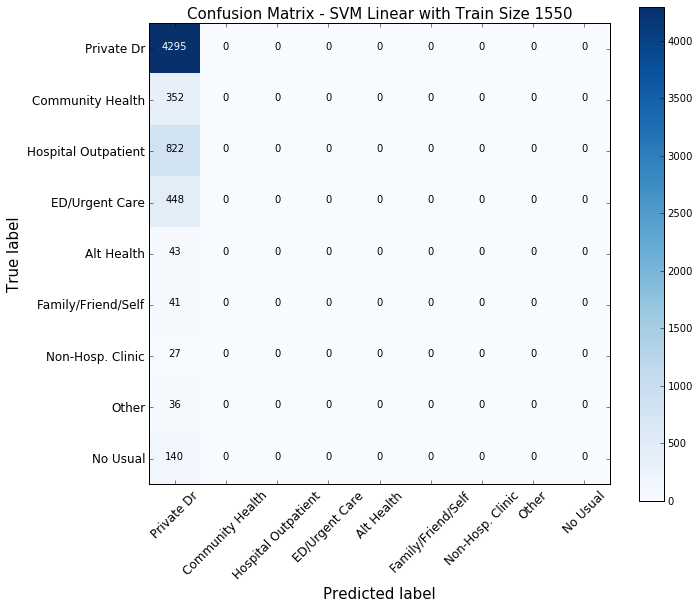

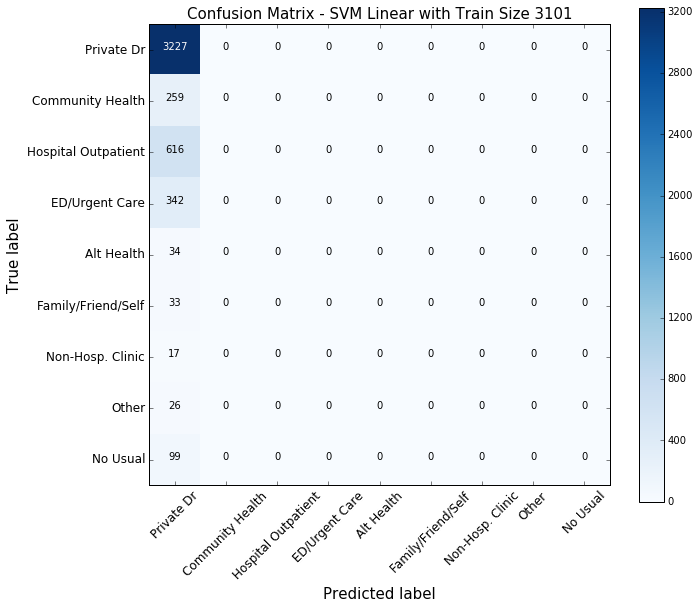

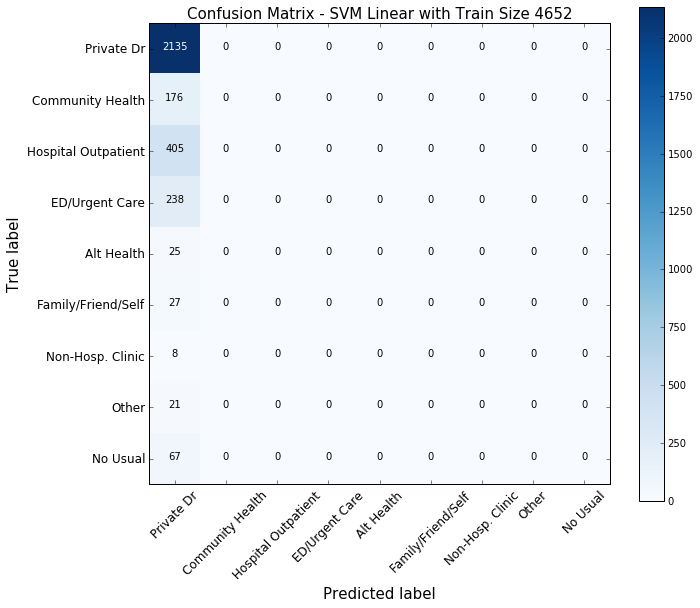

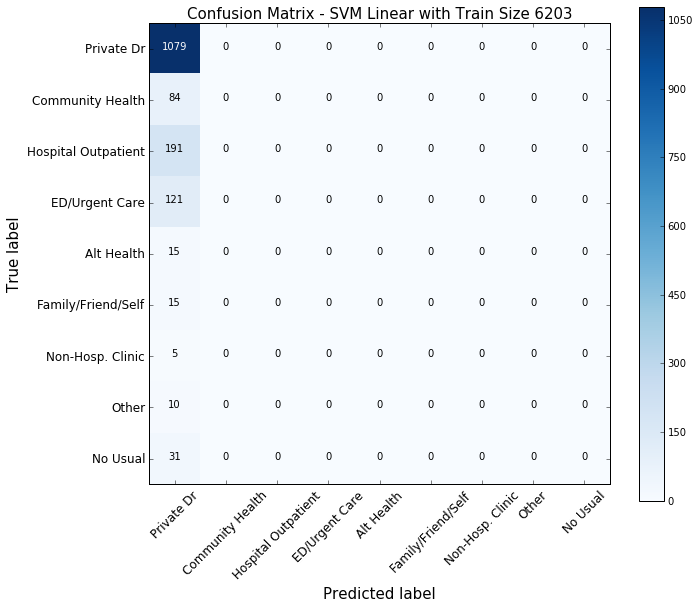

In [99]:
print("----------SVM Linear----------")

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_linear = svm.SVC(kernel='linear')
    svm_linear.fit(X_train, Y_train)
    ypred_svm_linear = svm_linear.predict(X_test)
    e_svm_linear = sum(ypred_svm_linear != Y_test)

    #scores_svm = cross_val_score(svm_linear, X, Y_train, cv=8)
    
    print('For training size of {0}'.format(len(X_train)))
    print(e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)")
    #print ('Average Cross Valid Score {0} %'.format(round(mean(scores_svm), 4) * 100))
    conf_m = confusion_matrix(Y_test, ypred_svm_linear)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))

In [91]:
print("SVM_Linear - Cross Valid")
scores_svm = np.zeros(4 * 8).reshape(4, 8)

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = n, random_state=3)
    #ts, = Y_test.shape

    svm_linear = svm.SVC(kernel='linear')
    #gnb.fit(X_train,Y_train)
    #ypred_gnb = gnb.predict(X_test)
    #incorrect = sum(Y_test != ypred_gnb) / ts 

    scores_sv = cross_val_score(svm_linear, X, Y, cv = ShuffleSplit(n_splits = 8, test_size = n))
    scores_svm[i] = scores_sv
    
    print('For training size of {0}'.format(len(X) * (1 - n)))
    #print("{0} misclassified data out of {1}, {2} %".format(sum(Y_test != ypred_gnb), ts, round(incorrect * 100, 4)))
    print ('Average Cross Valid Score {0} %'.format(round(mean(scores_sv) * 100, 4)))

SVM_Linear - Cross Valid
For training size of 1550.7999999999997
Average Cross Valid Score 69.1006 %
For training size of 3101.6000000000004
Average Cross Valid Score 69.5788 %
For training size of 4652.4
Average Cross Valid Score 69.431 %
For training size of 6203.200000000001
Average Cross Valid Score 69.6486 %


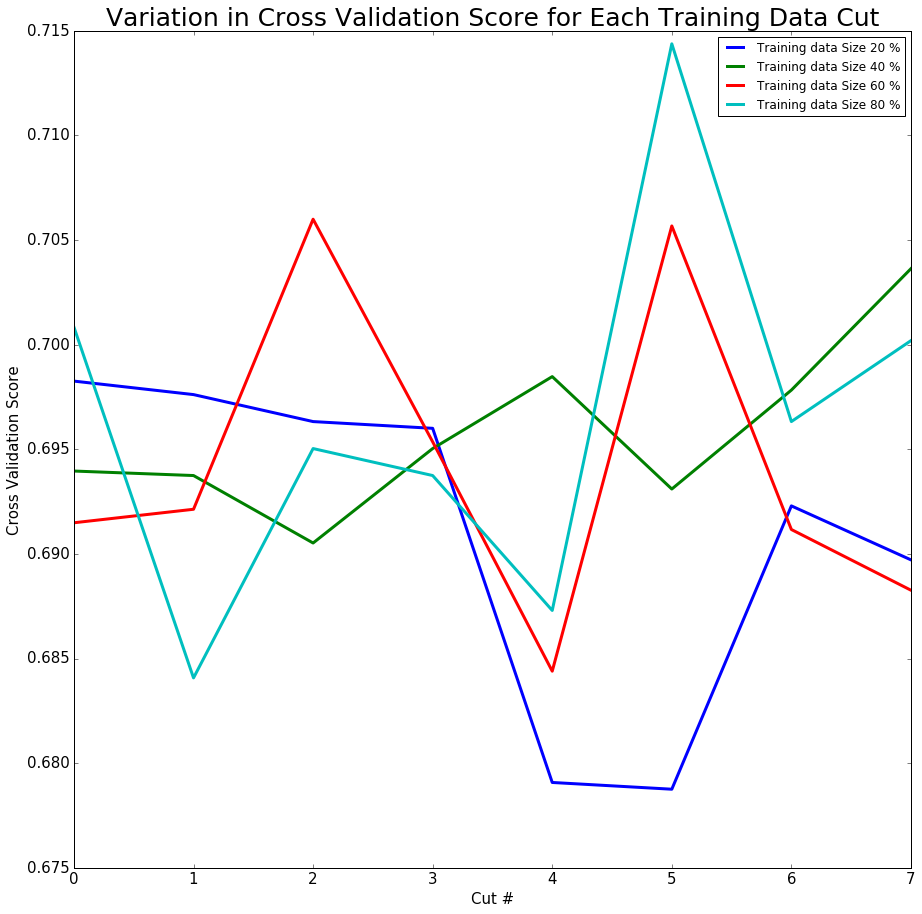

In [92]:
fig, ax = pl.subplots(figsize = (15, 15))
scores_ = np.zeros(4*8).reshape(4, 8)

for i, n in enumerate([0.2, 0.4, 0.6, 0.8]):
    ax.plot(range(0,8), scores_svm[i], label = 'Training data Size {0} %'.format(int(round(n * 100))), lw = 3)

pl.xlabel('Cut #', fontsize = 15)
pl.ylabel('Cross Validation Score', fontsize = 15)
pl.xticks(fontsize = 15)
pl.yticks(fontsize = 15)
pl.title('Variation in Cross Validation Score for Each Training Data Cut', fontsize = 25)
pl.legend()

For training size of 1550
----------SVM RBF----------
number of support vectors 654
1950 misclassified data out of 6204 ( 31.43 %)
For training size of 3101
----------SVM RBF----------
number of support vectors 1232
1442 misclassified data out of 4653 ( 30.99 %)
For training size of 4652
----------SVM RBF----------
number of support vectors 1761
976 misclassified data out of 3102 ( 31.46 %)
For training size of 6203
----------SVM RBF----------
number of support vectors 2327
477 misclassified data out of 1551 ( 30.75 %)


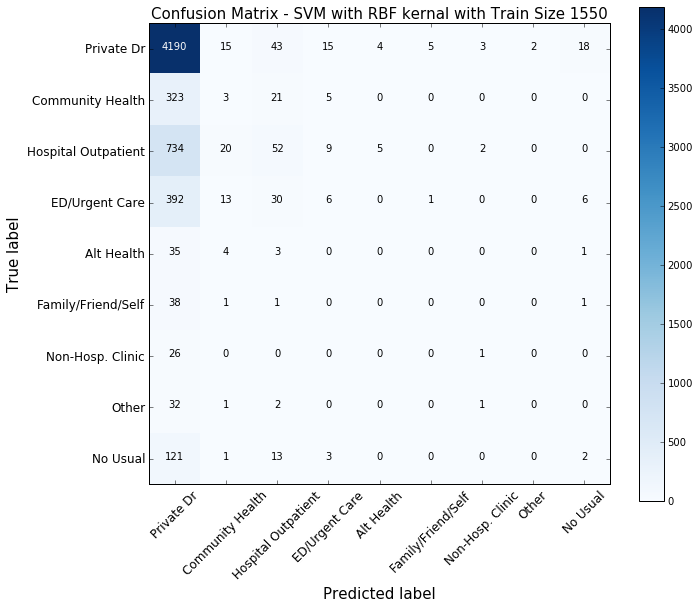

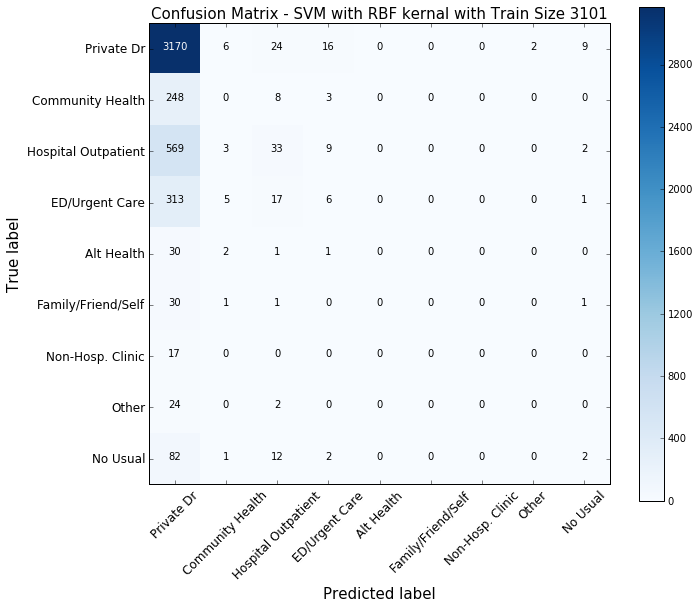

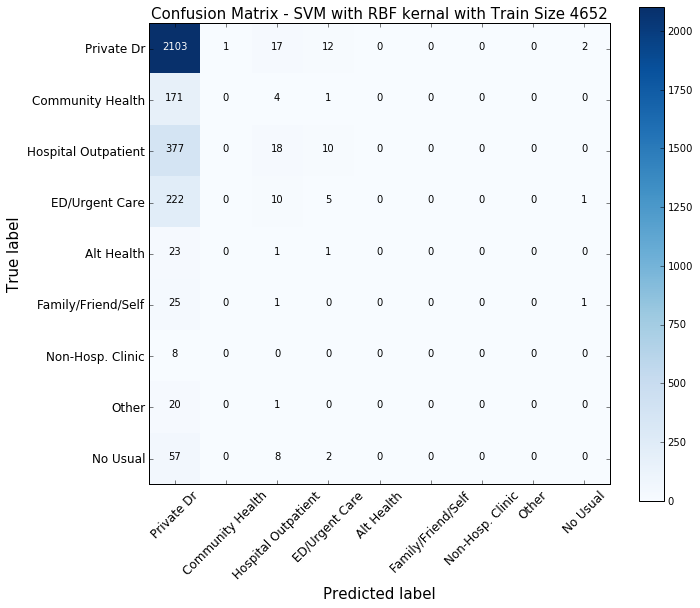

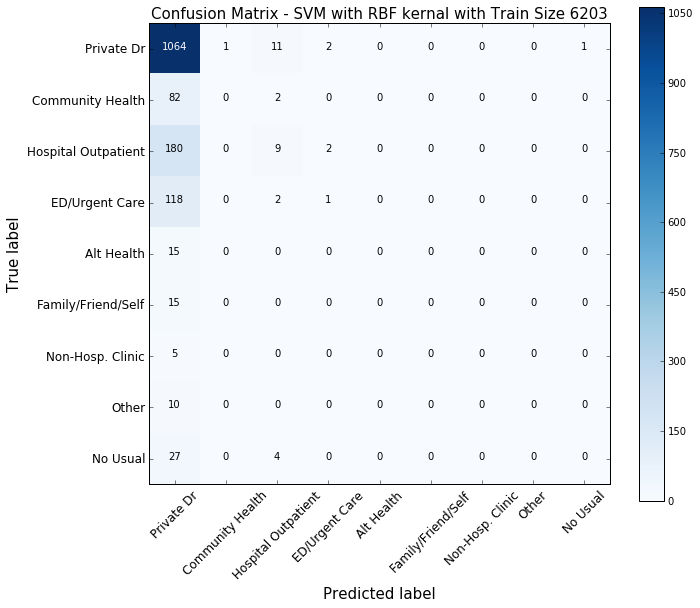

In [100]:
for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_rbf = svm.SVC(kernel='rbf', gamma=500, class_weight={1:5})
    svm_rbf.fit(X_train, Y_train)
    ypred_svm_rbf = svm_rbf.predict(X_test)
    e_svm_rbf = sum(ypred_svm_rbf != Y_test)

    #scores_rbf = cross_val_score(svm_rbf, X, Y, cv=8)
    
    print('For training size of {0}'.format(len(X_train)))
    print("----------SVM RBF----------")
    print("number of support vectors",len(svm_rbf.support_))
    print(e_svm_rbf, "misclassified data out of", ts, "(", round(e_svm_rbf/ts, 4) * 100,"%)")
    #print ('Average Cross Valid Score {0} %'.format(round(mean(scores_rbf), 4) * 100))
    conf_m = confusion_matrix(Y_test, ypred_svm_rbf)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - SVM with RBF kernal with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_RBF_CW1:5_{0}.jpg'.format(str(len(X_train))))

----------SVM RBF----------
For training size of 1550
number of support vectors 885
2178 misclassified data out of 6204 ( 35.11 %)
For training size of 3101
number of support vectors 1773
1617 misclassified data out of 4653 ( 34.75 %)
For training size of 4652
number of support vectors 2565
1104 misclassified data out of 3102 ( 35.59 %)
For training size of 6203
number of support vectors 3485
531 misclassified data out of 1551 ( 34.24 %)


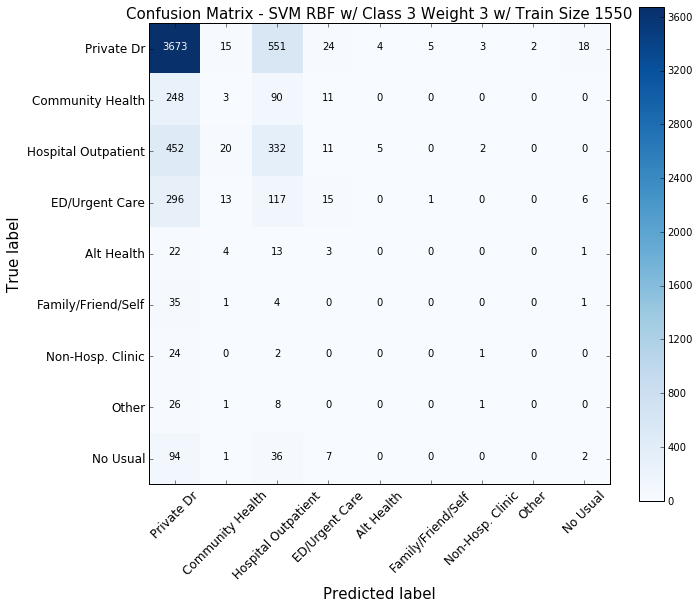

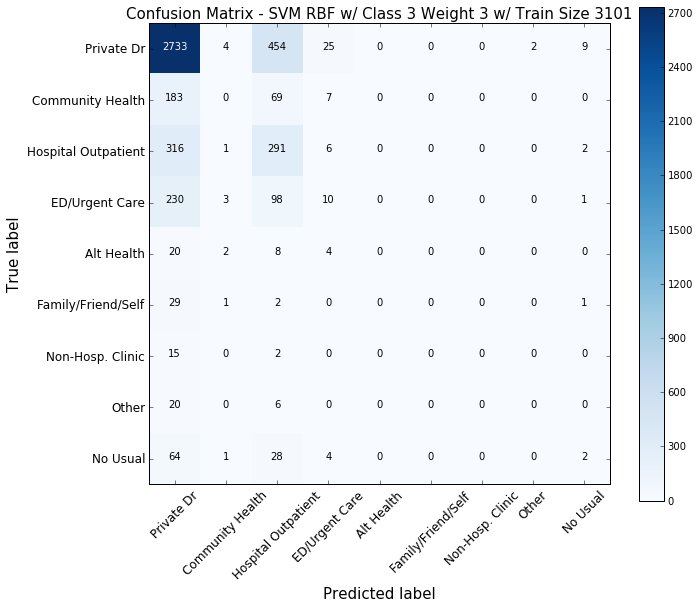

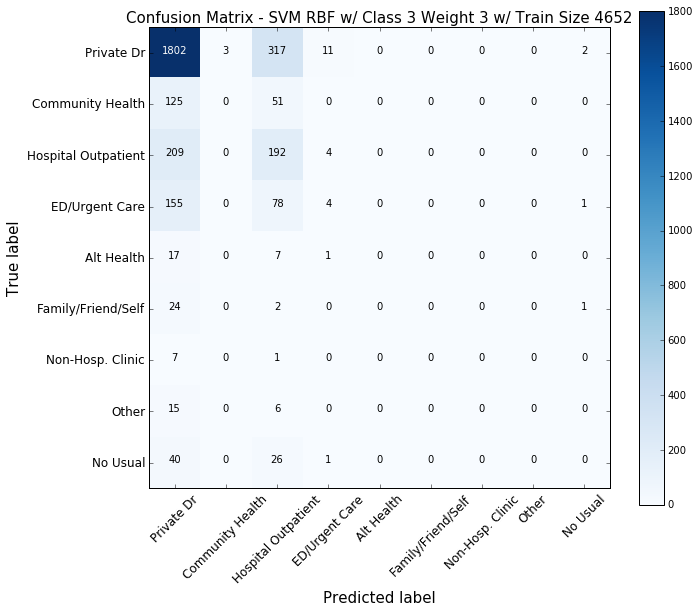

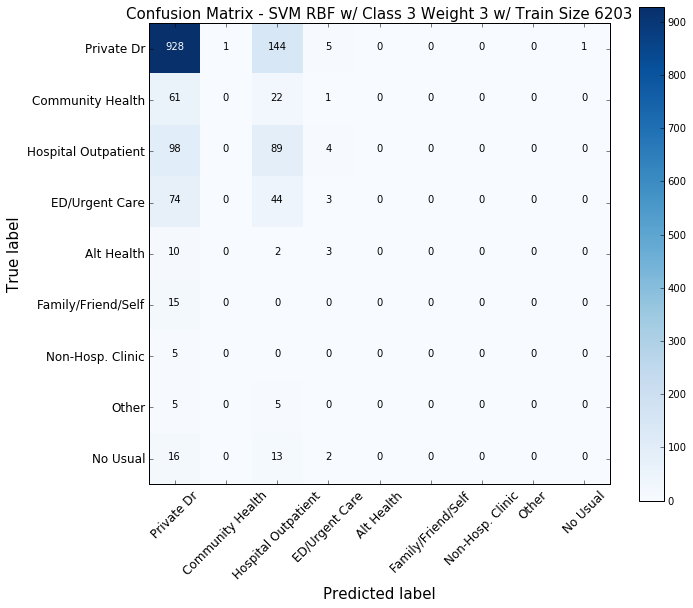

In [102]:
print("----------SVM RBF----------")

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_rbf = svm.SVC(kernel='rbf', gamma=500, class_weight={3:3})
    svm_rbf.fit(X_train, Y_train)
    ypred_svm_rbf = svm_rbf.predict(X_test)
    e_svm_rbf = sum(ypred_svm_rbf != Y_test)

    #scores_rbf = cross_val_score(svm_rbf, X, Y, cv=8)
    
    print('For training size of {0}'.format(len(X_train)))
    
    print("number of support vectors",len(svm_rbf.support_))
    print(e_svm_rbf, "misclassified data out of", ts, "(", round(e_svm_rbf/ts, 4) * 100,"%)")
    #print ('Average Cross Valid Score {0} %'.format(round(mean(scores_rbf), 4) * 100))
    conf_m = confusion_matrix(Y_test, ypred_svm_rbf)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
             title = 'Confusion Matrix - SVM RBF w/ Class 3 Weight 3 w/ Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_SVM_CW3_3_{0}.jpg'.format(str(len(X_train))))

----------SVM RBF 1st Class w/ Weight 3----------
For training size of 1550
number of support vectors 677
1954 misclassified data out of 6204 ( 31.5 %)
For training size of 3101
number of support vectors 1279
1443 misclassified data out of 4653 ( 31.01 %)
For training size of 4652
number of support vectors 1836
975 misclassified data out of 3102 ( 31.43 %)
For training size of 6203
number of support vectors 2437
477 misclassified data out of 1551 ( 30.75 %)


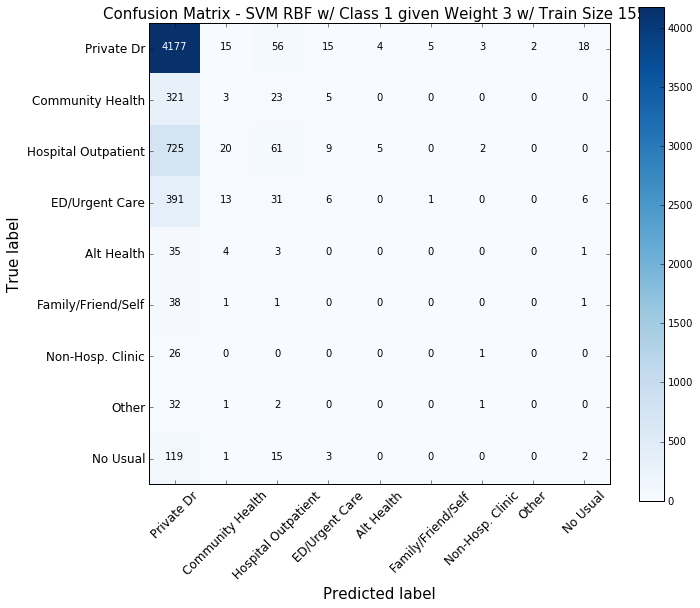

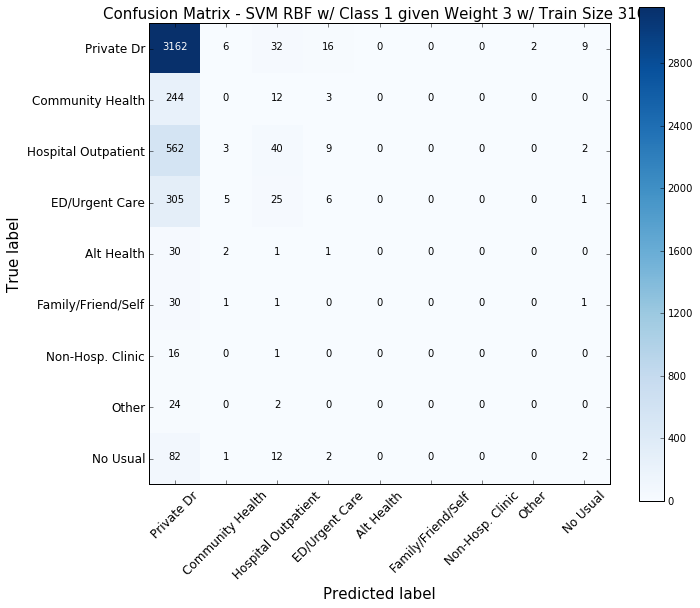

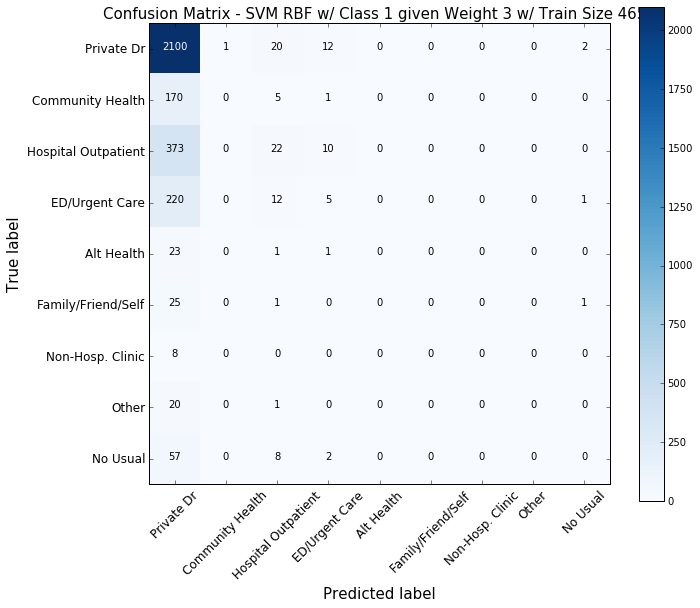

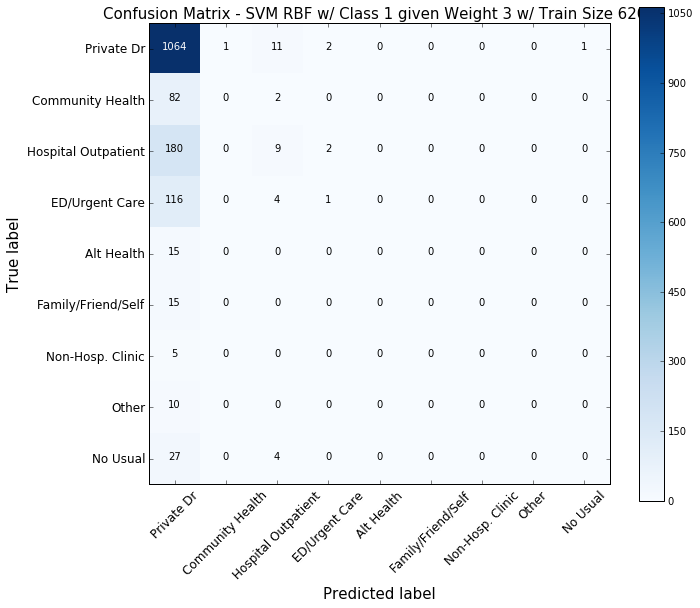

In [101]:
print("----------SVM RBF 1st Class w/ Weight 3----------")
for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_rbf = svm.SVC(kernel='rbf', gamma=500, class_weight={1:3})
    svm_rbf.fit(X_train, Y_train)
    ypred_svm_rbf = svm_rbf.predict(X_test)
    e_svm_rbf = sum(ypred_svm_rbf != Y_test)

    #scores_rbf = cross_val_score(svm_rbf, X, Y, cv=8)
    
    print('For training size of {0}'.format(len(X_train)))
    
    print("number of support vectors",len(svm_rbf.support_))
    print(e_svm_rbf, "misclassified data out of", ts, "(", round(e_svm_rbf/ts, 4) * 100,"%)")
    #print ('Average Cross Valid Score {0} %'.format(round(mean(scores_rbf), 4) * 100))
    conf_m = confusion_matrix(Y_test, ypred_svm_rbf)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
             title = 'Confusion Matrix - SVM RBF w/ Class 1 given Weight 3 w/ Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_CW1_3_{0}.jpg'.format(str(len(X_train))))

In [ ]:
plt.colorbar?